## **Deep Learning - How Does Urban Sustainability Look from Above?**

<small> The aim of this code is to calculate NDVI scores for each of the UNESCO's creative crities using satellite imagery from Google Earth Engine (GEE). Next, to use this data as a proxy for urban sustainability to answer the question: do cities become more sustainable when participating in the UNESCO's creative cities network?
Additionally, we have created an interactive map where the user can visualize the location of the UNESCO's creative cities and click on them to see details.

*   <small>Authors: Jessie Cameron, Dianni Adrei Banaga, Bianca Fernandes, and Dorian Godefroy
*   <small>Date: 27 April 2025

##### **Import Packages & Set-up GEE**

In [2]:
# !pip install earthengine-api
# !pip install geemap --quiet
# !pip install pandas geopy openpyxl

import ee
import pandas as pd
import geemap
import csv
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from google.colab import files
from geopy.extra.rate_limiter import RateLimiter
import concurrent.futures
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import folium

In [4]:
# Set project ID
project_id = 'deeplearning-457411'

# Authenticate and initalize earth engine
ee.Authenticate(auth_mode='notebook')
ee.Initialize(project=project_id)

##### **Import Creative Cities and Find Coordinates**

In [ ]:
# upload creative cities excel
uploaded = files.upload()

Saving Creative Cities.xlsx to Creative Cities.xlsx


In [ ]:
# Load the creative cities file
df = pd.read_excel("Creative Cities.xlsx")

# Combine city and country for geocoding
df['Location'] = df['City'] + ', ' + df['Country']
df.head()

,City,Country,Year,Creative Field,Location
0,Asaba,Nigeria,2023,Film,"Asaba, Nigeria"
1,Bitola,North Macedonia,2015,Film,"Bitola, North Macedonia"
2,Bradford,United Kingdom,2009,Film,"Bradford, United Kingdom"
3,Bristol,United Kingdom,2017,Film,"Bristol, United Kingdom"
4,Busan,South Korea,2014,Film,"Busan, South Korea"


In [ ]:
# Initialize geocoder
geolocator = Nominatim(user_agent="ndvi_city_locator", timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Apply geocoding
df['Coordinates'] = df['Location'].apply(geocode)
df['Latitude'] = df['Coordinates'].apply(lambda x: x.latitude if x else None)
df['Longitude'] = df['Coordinates'].apply(lambda x: x.longitude if x else None)

# Save the result
df.to_excel("cities_with_coordinates.xlsx", index=False)
files.download("cities_with_coordinates.xlsx")
df.head()

In [15]:
# find geocode for cities which did not pick-up in code above
cities = ["Bucheon", "Wonju", "Lubumbashi", "Perth, United Kingdom"]

# Geocode the cities
coordinates = [geocode(city) for city in cities]

# Prepare the dataframe with coordinates
df_coordinates = pd.DataFrame({
    'City': cities,
    'Coordinates': coordinates,
    'Latitude': [coord.latitude if coord else None for coord in coordinates],
    'Longitude': [coord.longitude if coord else None for coord in coordinates]
})

df_coordinates.head()

##### **Calculate NDVI Scores**

In [23]:
# upload creative cities with coordinates excel (avoid running above code)
uploaded = files.upload()

# read as df
df = pd.read_excel("cities_with_coordinates.xlsx")
df.head()

Saving cities_with_coordinates.xlsx to cities_with_coordinates (2).xlsx


,City,Country,Year,Creative Field,Location,Coordinates,Latitude,Longitude
0,Asaba,Nigeria,2023,Film,"Asaba, Nigeria","Asaba, Oshimili South, Delta, Nigeria",6.185882,6.729707
1,Bitola,North Macedonia,2015,Film,"Bitola, North Macedonia","Битола, Општина Битола, 7000, Северна Македонија",41.031601,21.330251
2,Bradford,United Kingdom,2009,Film,"Bradford, United Kingdom","Bradford, West Yorkshire, England, United Kingdom",53.794423,-1.751919
3,Bristol,United Kingdom,2017,Film,"Bristol, United Kingdom","Bristol, City of Bristol, West of England, Eng...",51.453802,-2.597298
4,Busan,South Korea,2014,Film,"Busan, South Korea","부산광역시, 대한민국",35.179953,129.075236


In [60]:
def get_landsat_ndvi(year, region, latitude):
    if latitude >= 0:  # Northern Hemisphere
        start_date = ee.Date.fromYMD(year, 6, 1)  # First day of June
        end_date = ee.Date.fromYMD(year, 9, 30)  # Last day of September
    else:  # Southern Hemisphere
        start_date = ee.Date.fromYMD(year, 12, 1)  # First day of December
        end_date = ee.Date.fromYMD(year + 1, 3, 31)  # Last day of March

    # Select collection based on year
    if year <= 2011:
        collection = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") \
            .filterBounds(region).filterDate(start_date, end_date) \
            .map(lambda img: img.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI'))
    elif year < 2022:
        collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(region).filterDate(start_date, end_date) \
            .map(lambda img: img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI'))
    else:
        collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
            .filterBounds(region).filterDate(start_date, end_date) \
            .map(lambda img: img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI'))

    # Get image count and mean image
    count = collection.size().getInfo()
    mean_image = collection.mean()

    return mean_image, count

In [61]:
def process_city_year(city, country, latitude, longitude, year):
    if pd.isna(latitude) or pd.isna(longitude):
        return {
            'City': city,
            'Country': country,
            'Year': year,
            'Latitude': latitude,
            'Longitude': longitude,
            'Mean_NDVI': None,
            'Image_Count': 0,
            'Note': 'Missing coordinates'
        }

    region = ee.Geometry.Point(longitude, latitude).buffer(5000)

    try:
        ndvi_img, image_count = get_landsat_ndvi(year, region, latitude)
        mean_dict = ndvi_img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=30,
            maxPixels=1e9
        ).getInfo()

        ndvi_value = mean_dict.get('NDVI', None)

    except Exception as e:
        ndvi_value = None
        image_count = 0

    return {
        'City': city,
        'Country': country,
        'Year': year,
        'Latitude': latitude,
        'Longitude': longitude,
        'Mean_NDVI': ndvi_value,
        'Image_Count': image_count
    }

In [62]:
# Initialize the list to hold results
results = []

# Function to process multiple cities and years in parallel
def process_all_cities(df, years):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for index, row in df.iterrows():
            city = row['City']
            country = row['Country']
            latitude = row['Latitude']
            longitude = row['Longitude']
            for year in years:
                futures.append(executor.submit(process_city_year, city, country, latitude, longitude, year))

        # Collect results as they finish
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())

# Call the function with the dataframe and years
process_all_cities(df, range(2004, 2024))

# Convert results to DataFrame
ndvi_df = pd.DataFrame(results)
ndvi_df.head()

,City,Country,Year,Latitude,Longitude,Mean_NDVI,Image_Count
0,Asaba,Nigeria,2009,6.185882,6.729707,NaN,0
1,Asaba,Nigeria,2010,6.185882,6.729707,NaN,0
2,Asaba,Nigeria,2004,6.185882,6.729707,NaN,0
3,Asaba,Nigeria,2007,6.185882,6.729707,NaN,0
4,Asaba,Nigeria,2005,6.185882,6.729707,NaN,0


In [64]:
# export dataframe
ndvi_df.to_excel("cities_ndvi.xlsx", index=False)
files.download("cities_ndvi.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# import NDVI city scores (avoid running above)
uploaded = files.upload()

# read as df
ndvi_df = pd.read_excel("cities_ndvi.xlsx")
ndvi_df.head()

Saving cities_ndvi.xlsx to cities_ndvi.xlsx


,City,Country,Year,Latitude,Longitude,Mean_NDVI,Image_Count
0,Asaba,Nigeria,2009,6.185882,6.729707,NaN,0
1,Asaba,Nigeria,2010,6.185882,6.729707,NaN,0
2,Asaba,Nigeria,2004,6.185882,6.729707,NaN,0
3,Asaba,Nigeria,2007,6.185882,6.729707,NaN,0
4,Asaba,Nigeria,2005,6.185882,6.729707,NaN,0


In [4]:
# drop observations where
final_df = ndvi_df[ndvi_df['Image_Count'] > 0].dropna()
final_df.head()

,City,Country,Year,Latitude,Longitude,Mean_NDVI,Image_Count
9,Asaba,Nigeria,2013,6.185882,6.729707,0.069347,1
10,Asaba,Nigeria,2015,6.185882,6.729707,0.145380,2
11,Asaba,Nigeria,2014,6.185882,6.729707,0.093656,2
12,Asaba,Nigeria,2017,6.185882,6.729707,0.173711,3
14,Asaba,Nigeria,2019,6.185882,6.729707,0.078650,2


##### **Descriptive Statistics**

In [5]:
# count how many unique cities
final_df['City'].nunique()

262

In [57]:
# inspect melbourne in 2019
point = ee.Geometry.Point(144.9631732, -37.8142454).buffer(5000)

# Load Landsat images for 2019
images = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(point) \
    .filterDate('2019-01-01', '2019-12-31')

# Compute the median composite of the images
median_image = images.median()

# Visualize the result on an interactive map
Map = geemap.Map()
Map.centerObject(point, 10)  # Set the map center to Melbourne
vis_params = {
    'bands': ['SR_B5', 'SR_B4', 'SR_B3'],  # Select the Red, Green, and Blue bands
    'min': 5000,
    'max': 15000
}
Map.addLayer(median_image, vis_params, "Landsat 8 Median Composite 2019")

# Display the map
Map

Map(center=[-37.814240270556844, 144.96317338005545], controls=(WidgetControl(options=['position', 'transparen…

In [59]:
## Create summary statistics
summary_stats = final_df.describe()
print(summary_stats)

              Year     Latitude    Longitude    Mean_NDVI  Image_Count
count  5658.000000  5658.000000  5658.000000  5658.000000  5658.000000
mean   2013.956875    29.353042    27.597736     0.130602    16.334924
std       5.830792    27.073050    66.486247     0.062064     8.190548
min    2004.000000   -45.874098  -122.330062    -0.254205     1.000000
25%    2009.000000    19.758952    -2.970190     0.084080    10.000000
50%    2015.000000    37.752531    18.417220     0.127562    16.000000
75%    2019.000000    47.481390    74.314183     0.174616    22.000000
max    2023.000000    65.011787   175.051931     0.395484    49.000000


##### **Inclusion of control variables**

In [4]:
# Load Data
df = pd.read_excel('merged_data.xlsx')

# Rename columns
df = df.rename(columns={
    'Average annual rate of change of the urban population share (estimates)': 'Urban_Pop_Change',
    'Population Growth': 'Population_Growth',
    'GDP Growth': 'GDP_Growth'
})

# Sort before interpolation
df = df.sort_values(by=['City', 'Observation'])

# Interpolate Urban_Pop_Change within each city
df['Urban_Pop_Change'] = df.groupby('City')['Urban_Pop_Change'].transform(
    lambda group: group.interpolate(method='linear').bfill().ffill()
)


# Standardize control variables
control_vars = ['Urban_Pop_Change', 'Population_Growth', 'GDP_Growth']

##### **Event Study**

In [5]:
for var in control_vars:
    df[f'{var}_std'] = (df[var] - df[var].mean()) / df[var].std()

# Standardize Mean_NDVI
df['Mean_NDVI_std'] = (df['Mean_NDVI'] - df['Mean_NDVI'].mean()) / df['Mean_NDVI'].std()

# Create EventTime variable
df['EventTime'] = df['Observation'] - df['Oldest year of nomination']

# Subset for event window AFTER everything is prepared
df_event = df[(df['EventTime'] >= -3) & (df['EventTime'] <= 7)].copy()

# Create event dummies in df_event
event_vars = []
for k in range(-3, 8):
    if k != -1:   # -1 is reference
        if k > 0:
            dummy_name = f'event_p{k}'
        elif k == 0:
            dummy_name = 'event_0'
        else:
            dummy_name = f'event_m{abs(k)}'
        df_event[dummy_name] = (df_event['EventTime'] == k).astype(int)
        event_vars.append(dummy_name)

# Define formula parts
event_dummies = ' + '.join(event_vars)
controls = ' + '.join([f'{var}_std' for var in control_vars])

# Regression formula
formula = f"Mean_NDVI_std ~ {event_dummies} + {controls} + C(City)"

# Ensure no missing data
relevant_vars = ['Mean_NDVI_std'] + event_vars + [f'{var}_std' for var in control_vars] + ['City', 'Observation']
df_reg = df_event.dropna(subset=relevant_vars)

# Run regression
model = smf.ols(formula, data=df_reg).fit(cov_type='cluster', cov_kwds={'groups': df_reg['City']})

# View summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Mean_NDVI_std   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     106.8
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           1.13e-83
Time:                        12:32:36   Log-Likelihood:                -507.61
No. Observations:                1266   AIC:                             1453.
Df Residuals:                    1047   BIC:                             2580.
Df Model:                         218                                         
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 218, but rank is 13
  warnings.warn('covariance of constraints does not have full '


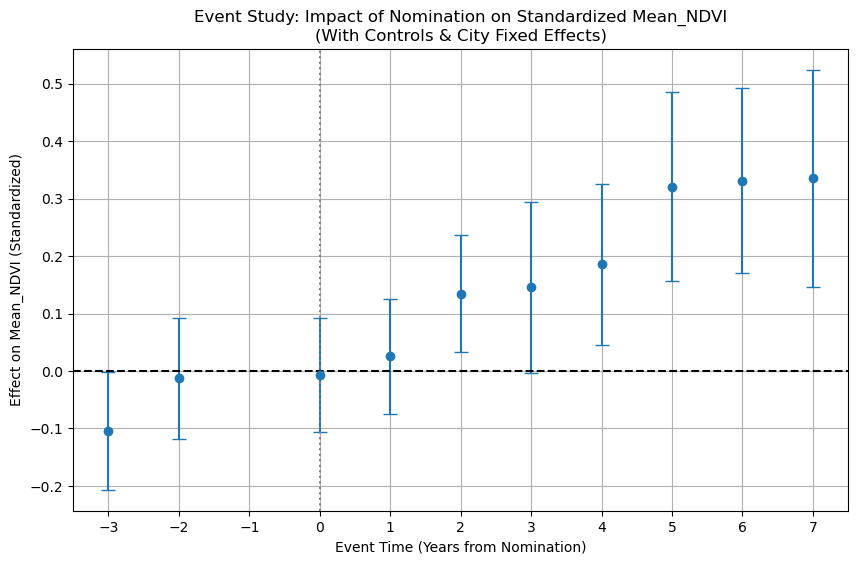

In [6]:
#Event Study Plot

# Extract coefficients and confidence intervals for event dummies
coef = model.params[event_vars]
conf_int = model.conf_int().loc[event_vars]

# Map event dummies to actual event times
event_times = []
for var in event_vars:
    if 'm' in var:
        event_times.append(-int(var.split('m')[1]))
    elif 'p' in var:
        event_times.append(int(var.split('p')[1]))
    else:
        event_times.append(0)

# Sort by event time
event_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coef.values,
    'ci_lower': conf_int[0].values,
    'ci_upper': conf_int[1].values
}).sort_values(by='event_time')

# Plot
plt.figure(figsize=(10,6))
plt.errorbar(event_df['event_time'], event_df['coef'], 
             yerr=[event_df['coef'] - event_df['ci_lower'], event_df['ci_upper'] - event_df['coef']],
             fmt='o', capsize=5)

plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='grey', linestyle=':')
plt.title('Event Study: Impact of Nomination on Standardized Mean_NDVI\n(With Controls & City Fixed Effects)')
plt.xlabel('Event Time (Years from Nomination)')
plt.ylabel('Effect on Mean_NDVI (Standardized)')
plt.xticks(range(-3, 8))
plt.grid(True)
plt.show()

##### **Heterogeneity Analysis**

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 217, but rank is 12
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:          Mean_NDVI_std   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     98.99
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           2.50e-78
Time:                        12:33:54   Log-Likelihood:                -513.32
No. Observations:                1266   AIC:                             1463.
Df Residuals:                    1048   BIC:                             2584.
Df Model:                         217                                         
Covariance Type:              cluster                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

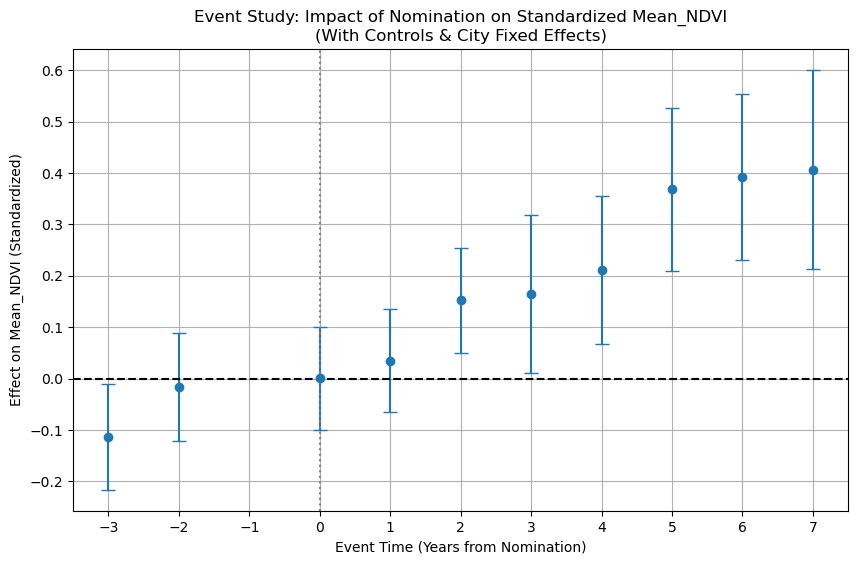

In [8]:
#Regression without Urban Population Change (in Preparation for Heterogeneity Analysis)

# Load Data
df = pd.read_excel('merged_data.xlsx')

# Rename columns
df = df.rename(columns={
    'Average annual rate of change of the urban population share (estimates)': 'Urban_Pop_Change',
    'Population Growth': 'Population_Growth',
    'GDP Growth': 'GDP_Growth'
})

# Sort before interpolation
df = df.sort_values(by=['City', 'Observation'])

# Interpolate Urban_Pop_Change within each city
df['Urban_Pop_Change'] = df.groupby('City')['Urban_Pop_Change'].transform(
    lambda group: group.interpolate(method='linear').bfill().ffill()
)


# Standardize control variables
control_vars = ['Population_Growth', 'GDP_Growth']

for var in control_vars:
    df[f'{var}_std'] = (df[var] - df[var].mean()) / df[var].std()

# Standardize Mean_NDVI
df['Mean_NDVI_std'] = (df['Mean_NDVI'] - df['Mean_NDVI'].mean()) / df['Mean_NDVI'].std()

# Create EventTime variable
df['EventTime'] = df['Observation'] - df['Oldest year of nomination']

# Subset for event window AFTER everything is prepared
df_event = df[(df['EventTime'] >= -3) & (df['EventTime'] <= 7)].copy()

# Create event dummies in df_event
event_vars = []
for k in range(-3, 8):
    if k != -1:   # -1 is reference
        if k > 0:
            dummy_name = f'event_p{k}'
        elif k == 0:
            dummy_name = 'event_0'
        else:
            dummy_name = f'event_m{abs(k)}'
        df_event[dummy_name] = (df_event['EventTime'] == k).astype(int)
        event_vars.append(dummy_name)

# Define formula parts
event_dummies = ' + '.join(event_vars)
controls = ' + '.join([f'{var}_std' for var in control_vars])

# Regression formula
formula = f"Mean_NDVI_std ~ {event_dummies} + {controls} + C(City)"

# Ensure no missing data
relevant_vars = ['Mean_NDVI_std'] + event_vars + [f'{var}_std' for var in control_vars] + ['City', 'Observation']
df_reg = df_event.dropna(subset=relevant_vars)

# Run regression
model = smf.ols(formula, data=df_reg).fit(cov_type='cluster', cov_kwds={'groups': df_reg['City']})

# View summary
print(model.summary())

# Extract coefficients and confidence intervals for event dummies
coef = model.params[event_vars]
conf_int = model.conf_int().loc[event_vars]

# Map event dummies to actual event times
event_times = []
for var in event_vars:
    if 'm' in var:
        event_times.append(-int(var.split('m')[1]))
    elif 'p' in var:
        event_times.append(int(var.split('p')[1]))
    else:
        event_times.append(0)

# Sort by event time
event_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coef.values,
    'ci_lower': conf_int[0].values,
    'ci_upper': conf_int[1].values
}).sort_values(by='event_time')

# Plot
plt.figure(figsize=(10,6))
plt.errorbar(event_df['event_time'], event_df['coef'], 
             yerr=[event_df['coef'] - event_df['ci_lower'], event_df['ci_upper'] - event_df['coef']],
             fmt='o', capsize=5)

plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='grey', linestyle=':')
plt.title('Event Study: Impact of Nomination on Standardized Mean_NDVI\n(With Controls & City Fixed Effects)')
plt.xlabel('Event Time (Years from Nomination)')
plt.ylabel('Effect on Mean_NDVI (Standardized)')
plt.xticks(range(-3, 8))
plt.grid(True)
plt.show()

/var/folders/32/lx8kp8jx68zdmbtv217708z80000gn/T/ipykernel_12189/2791618732.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['Urban_Pop_Quartile'] = df_reg['City'].map(city_quartiles)



--- Running Event Study for Urban Pop Change Quartile: Q1 ---


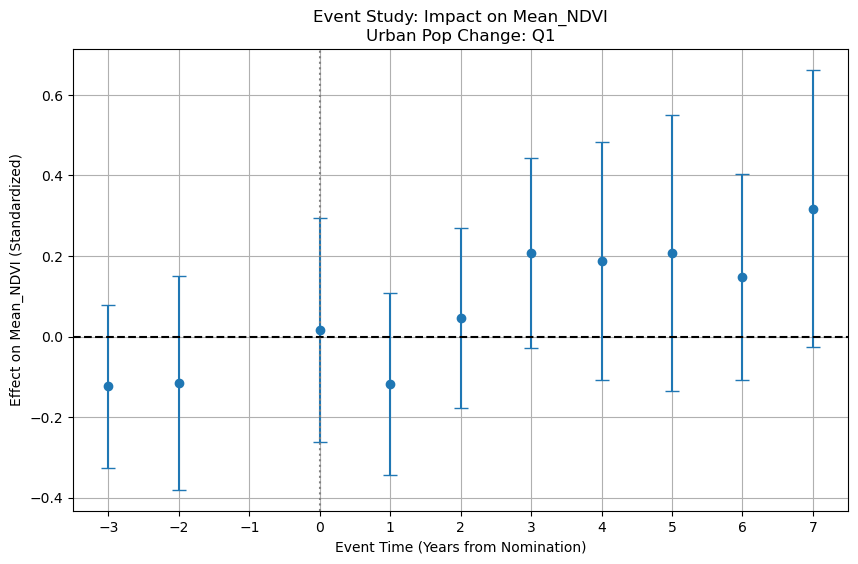


--- Running Event Study for Urban Pop Change Quartile: Q2 ---


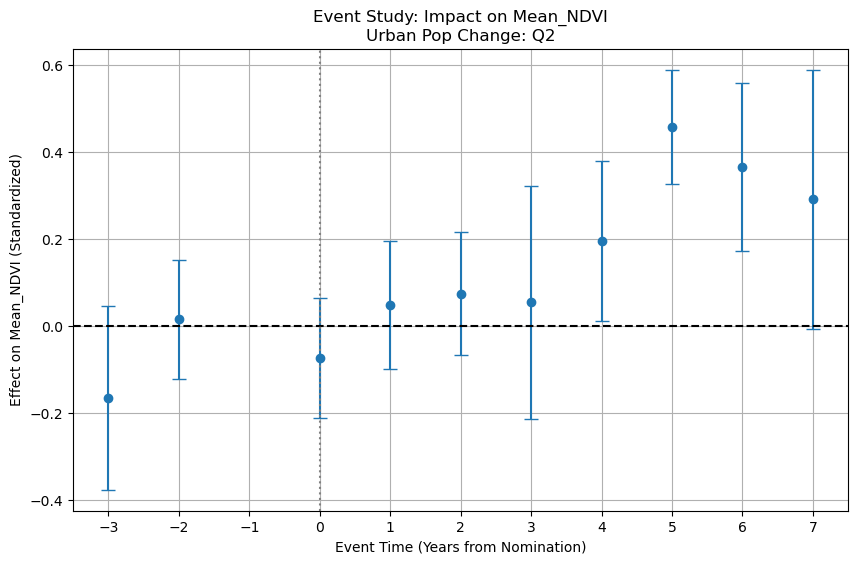


--- Running Event Study for Urban Pop Change Quartile: Q3 ---


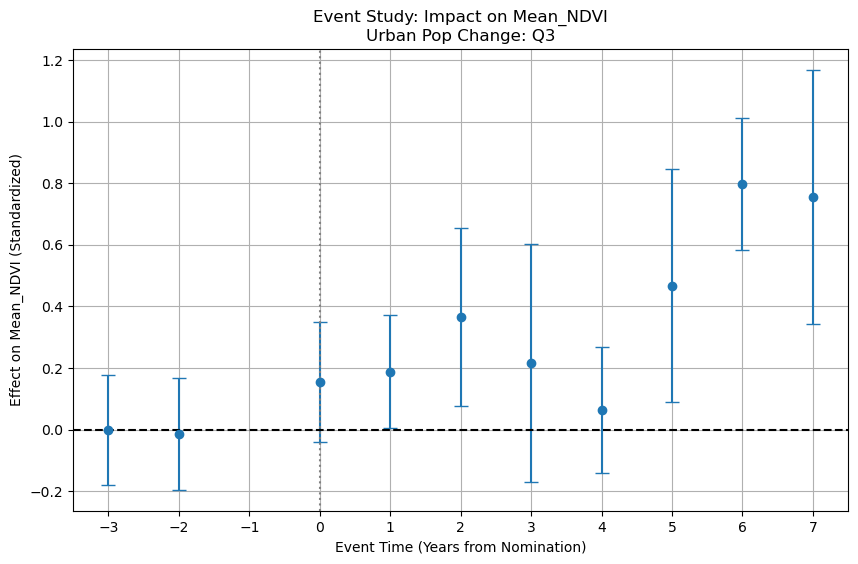


--- Running Event Study for Urban Pop Change Quartile: Q4 ---


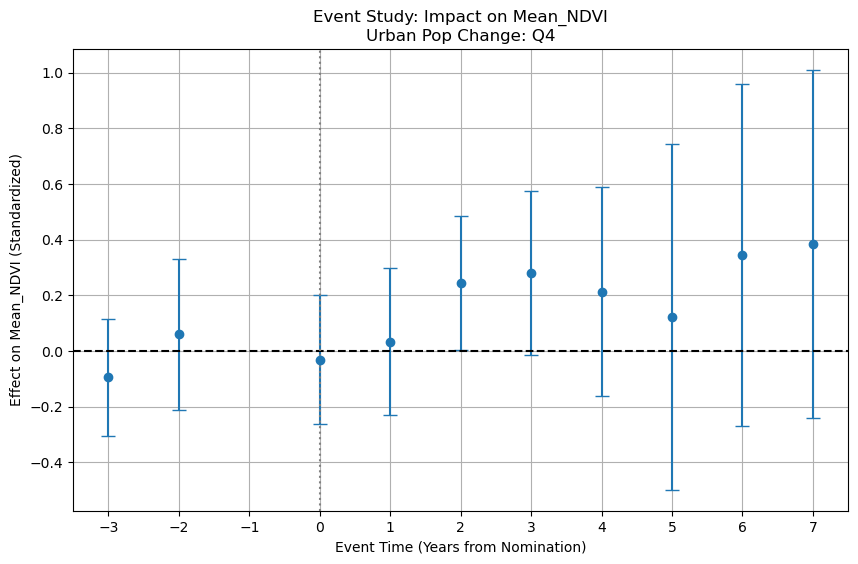

In [9]:
#Heterogeneity across Urban Population Change

# Calculate average Urban_Pop_Change per City
city_avg_urban_pop = df.groupby('City')['Urban_Pop_Change'].mean()

# Assign quartiles
city_quartiles = pd.qcut(city_avg_urban_pop, q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Merge quartile info back to the main dataframe
df_reg['Urban_Pop_Quartile'] = df_reg['City'].map(city_quartiles)


quartile_labels = ['Q1', 'Q2', 'Q3', 'Q4']

for quartile in quartile_labels:
    print(f"\n--- Running Event Study for Urban Pop Change Quartile: {quartile} ---")
    
    # Subset data
    df_quartile = df_reg[df_reg['Urban_Pop_Quartile'] == quartile]
    
    # Skip if too few observations
    if len(df_quartile) < 50:
        print(f"Not enough data for {quartile}, skipping...")
        continue

    # Run regression
    model = smf.ols(formula, data=df_quartile).fit(cov_type='cluster', cov_kwds={'groups': df_quartile['City']})
    
    # Extract coefficients and confidence intervals
    coef = model.params[event_vars]
    conf_int = model.conf_int().loc[event_vars]

    # Map event times
    event_times = []
    for var in event_vars:
        if 'm' in var:
            event_times.append(-int(var.split('m')[1]))
        elif 'p' in var:
            event_times.append(int(var.split('p')[1]))
        else:
            event_times.append(0)

    # Prepare dataframe
    event_df = pd.DataFrame({
        'event_time': event_times,
        'coef': coef.values,
        'ci_lower': conf_int[0].values,
        'ci_upper': conf_int[1].values
    }).sort_values(by='event_time')

    # Plot
    plt.figure(figsize=(10,6))
    plt.errorbar(event_df['event_time'], event_df['coef'], 
                 yerr=[event_df['coef'] - event_df['ci_lower'], event_df['ci_upper'] - event_df['coef']],
                 fmt='o', capsize=5)

    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(0, color='grey', linestyle=':')
    plt.title(f'Event Study: Impact on Mean_NDVI\nUrban Pop Change: {quartile}')
    plt.xlabel('Event Time (Years from Nomination)')
    plt.ylabel('Effect on Mean_NDVI (Standardized)')
    plt.xticks(range(-3, 8))
    plt.grid(True)
    plt.show()

##### **Creative Cities Interactive Map** 

In [ ]:
CreativeCities = pd.read_excel("cities_with_coordinates.xlsx")
CreativeCities = CreativeCities.sort_values("Year")
CreativeCitiesDupes = CreativeCities.drop_duplicates(subset="City")
CreativeCitiesDupes = CreativeCitiesDupes.sort_values("City")

assign_color = {"Gastronomy": "#DC143C",  # Deep Intense Red
                "Crafts and Arts": "#7851A9",  # Deep Vibrant Purple
                "Literature": "#00FFFF",  # Bright Cyan
                "Music": "#4B0082",  # Deep Cool Indigo
                "Design": "#FFC300",  # Rich Bold Yellow
                "Media Arts": "#32CD32",  # Fresh Lime
                "Film": "#FF6F61"  # Vivid Coral Pink
                }


CreativeCitiesDupes['Color'] = CreativeCitiesDupes['Creative Field'].map(assign_color)
 

World = folium.Map(location=[0, 0], zoom_start=2.2)
fg = folium.FeatureGroup(name="Creative Cities Map")


for name, category, year, lat, long, color in zip(CreativeCitiesDupes["City"],
                                                  CreativeCitiesDupes["Creative Field"],
                                                  CreativeCitiesDupes["Year"],
                                                  CreativeCitiesDupes["Latitude"],
                                                  CreativeCitiesDupes["Longitude"],
                                                  CreativeCitiesDupes["Color"]):

    popup_content = folium.Popup(f"{name}: {category} in {year}", max_width=250)

    fg.add_child(folium.Circle(location=(lat, long),
                               radius=20000,
                               fill_opacity=0.7,
                               color=color,
                               fill_color=color,
                               popup=popup_content))

World.add_child(fg)

legend_html = """
     <div style="
     position: fixed; 
     bottom: 50px; left: 50px; width: 220px; height: auto; 
     background-color: white;
     border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px;
     border-radius: 8px;
     box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
     ">
     <b>Cities Creativity in</b><br><br>
     <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background:#4B0082; width:12px; height:12px; border-radius:50%; margin-right:8px;"></div> Music
     </div>
     <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background:#FFC300; width:12px; height:12px; border-radius:50%; margin-right:8px;"></div> Design
     </div>
     <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background:#32CD32; width:12px; height:12px; border-radius:50%; margin-right:8px;"></div> Media Arts
     </div>
     <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background:#DC143C; width:12px; height:12px; border-radius:50%; margin-right:8px;"></div> Gastronomy
     </div>
     <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background:#7851A9; width:12px; height:12px; border-radius:50%; margin-right:8px;"></div> Crafts & Arts
     </div>
     <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background:#FF6F61; width:12px; height:12px; border-radius:50%; margin-right:8px;"></div> Film
     </div>
     <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background:#00FFFF; width:12px; height:12px; border-radius:50%; margin-right:8px;"></div> Literature
     </div>
     </div>
"""


World.get_root().html.add_child(folium.Element(legend_html))

# World.save("creative_cities_map.html")
World